## ARMA TASK

In [ ]:
%pip install scipy

# Make sure you have statsmodels >0.9.0 as it fails to import statsmodels.api
# see https://github.com/statsmodels/statsmodels/issues/5759
%pip install git+https://github.com/statsmodels/statsmodels

In [24]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('Solarize_Light2')
style.use('Solarize_Light2')
%matplotlib inline
print(plt.style.available)
import matplotlib as mpl
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

mpl.rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = 6,5

['seaborn-notebook', 'seaborn-deep', 'tableau-colorblind10', 'seaborn-colorblind', 'dark_background', 'seaborn-dark', 'seaborn-paper', 'seaborn-muted', '_classic_test', 'seaborn-ticks', 'fast', 'seaborn-darkgrid', 'seaborn', 'seaborn-pastel', 'bmh', 'seaborn-whitegrid', 'seaborn-poster', 'Solarize_Light2', 'ggplot', 'fivethirtyeight', 'classic', 'seaborn-white', 'seaborn-bright', 'seaborn-talk', 'seaborn-dark-palette', 'grayscale']


In [25]:
df = pd.DataFrame(pd.read_csv('BATADAL_trainingset1.csv')) # No attacks
df_attacks = pd.DataFrame(pd.read_csv('BATADAL_trainingset2.csv')) # With attacks
df_nolabels = pd.DataFrame(pd.read_csv('BATADAL_test_dataset.csv')) # With attacks no labels
pd.set_option('display.expand_frame_repr', False)


# Autocorrelation function

We calculate the autocorrelation and partial autocorrelation functions to make an informed descision about what ARMA parameters to use.


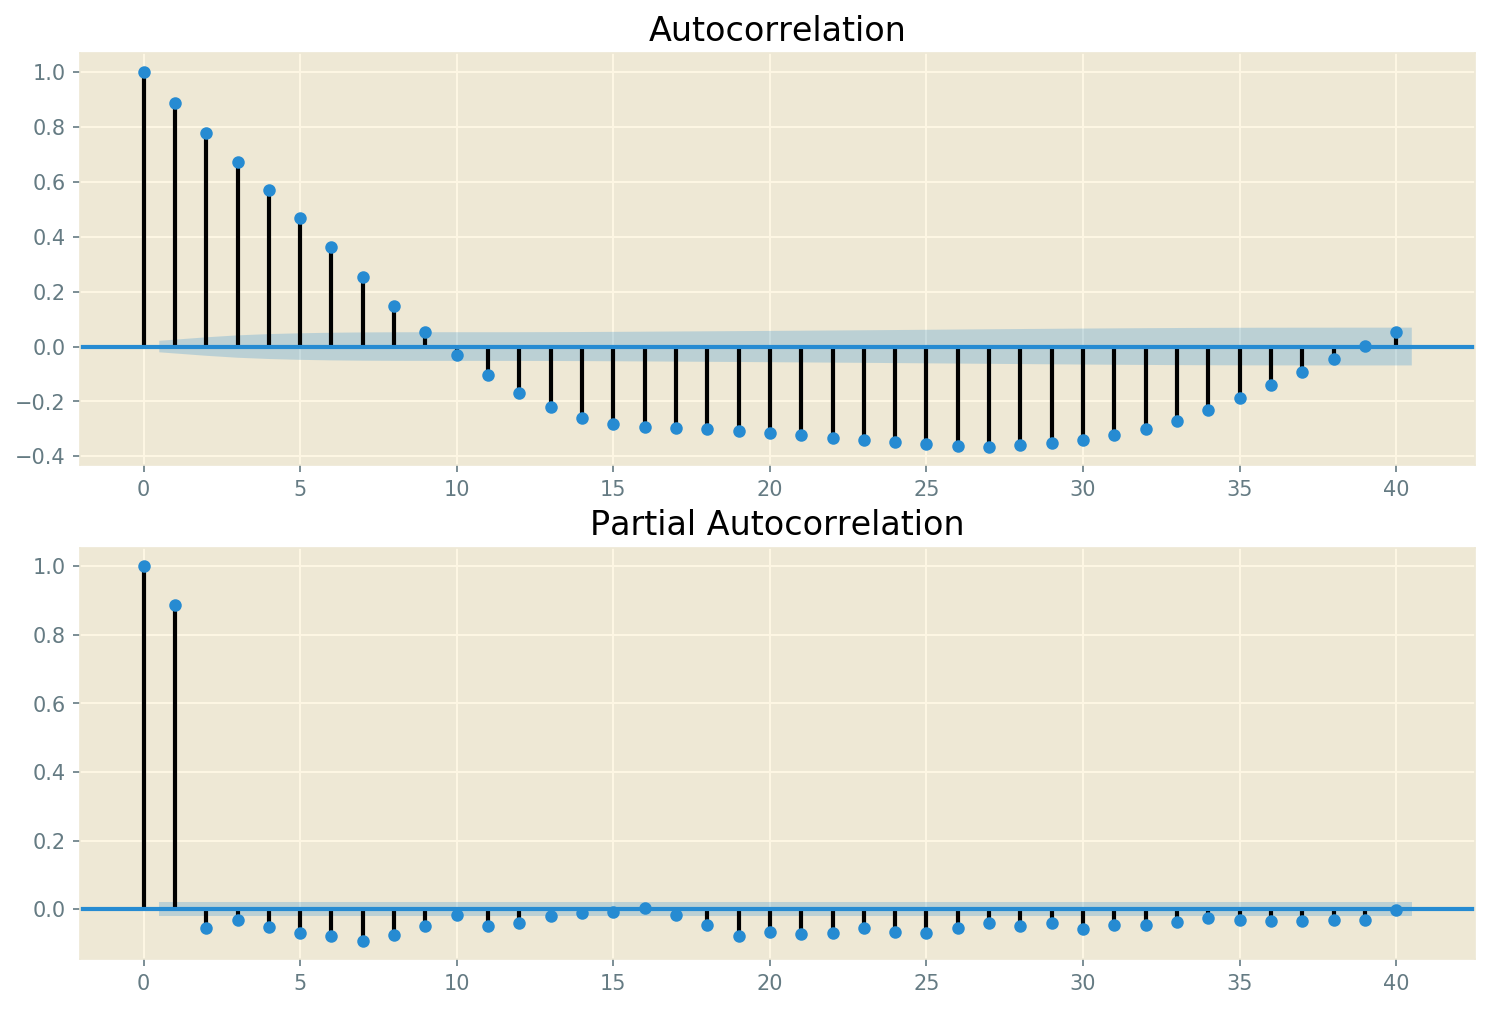

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['F_PU1'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['F_PU1'], lags=40, ax=ax2)

## ARMA parameters rules of thumb:

- Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1, and no correlation for other lags, then use one autoregressive (p)parameter
- Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters
- Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, and the PACF damps out exponentially, then use one moving average (q) parameter.
- Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags, and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.
- Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter.


In [27]:
class dummy:
    aic = 99999999
    
#    "The higher the AR order gets, the lower the AIC gets." you care about the rate of change. When the AIC does not drop substantially with the increase of an AR term, the search can stop for that sensor. 
def test_arma_params(train_series, test_series, params, attack_flags):
    # Find optimal parameters based on AIC 
    arma_mod = sm.tsa.ARMA(train_series, (0,0)).fit()
    
    zero_aic = arma_mod.aic
    best_params = params[0]
    lowest_aic = arma_mod.aic
    prev_aic = arma_mod.aic
    
    print(f"first aic is {prev_aic}")
    for param_set in params:
        print("testing " + str(param_set))
        try:
            arma_mod = sm.tsa.ARMA(train_series, param_set).fit()
            print(str(arma_mod.aic))
        except:
            print("erorr")
            arma_mod = dummy()
        print(f"Change: {arma_mod.aic - prev_aic}, change vs first: {arma_mod.aic - zero_aic}")
        prev_aic = arma_mod.aic
        if arma_mod.aic < lowest_aic:
            lowest_aic = arma_mod.aic
            best_params = param_set
#         print(sm.stats.durbin_watson(arma_mod.resid.values))
#         print(arma_mod.params)
#         print(arma_mod.aic, arma_mod.bic, arma_mod.hqic)
        
    print('best params: ' + str(best_params))


def do_arma(train_series, test_series, params, attack_flags):
    print(f'####################################\nCurrent Series: {train_series.name}\n####################################')
    train_model = sm.tsa.ARMA(train_series, params).fit()#method='mle', trend='nc')
    print(str(train_model.params))
    test_model = sm.tsa.ARMA(test_series, params).fit(start_params = train_model.params)#, start_ar_lags=6, method='mle', trend='nc')

    #The equations are somewhat simpler if the time series is first reduced to zero-mean by subtracting the sample mean. Therefore, we will work with the mean-adjusted series

    # Plotting the residuals
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    resid = test_model.resid
    ax = resid.plot(ax=ax);

    # +
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    # -

#     stats.normaltest(resid)

    # ## ARMA Model Autocorrelation
    print("Autocorrelation plots:")
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

    # ## Prediction

    prediction = test_model.predict()
    pd.DataFrame({"prediction":prediction[100:400],
                "actual": train_series[100:400]}).plot(figsize=(20,10))
#     return prediction

    # ## Anomaly detection    
    std = np.std(test_model.resid)
    anomaly_thresh = 1.5 * std
    detected_anomalies = test_model.resid[test_model.resid > anomaly_thresh]
    test_model = pd.DataFrame({ 'ATT_FLAG': attack_flags })
    tp=0
    fp=0
    for index, _ in detected_anomalies.items():
        if attack_flags[index]==1:
            tp+=1
        else:
            fp+=1
    tn=test_model.loc[attack_flags==-999].shape[0]-fp
    fn=test_model.loc[attack_flags==1].shape[0]-tp
    Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
    if (tp+fp)!=0:
        Precision=100.0*tp / (tp + fp)
    else:
        Precision=0
    Recall = 100.0*tp / (tp + fn)
    F_score = 100.0*2*tp /(2*tp + fp + fn)
    print ("TP:", tp)
    print ("FP:", fp)
    print("Accuracy: %.2f" % Accuracy)
    print("Precision: %.2f" % Precision)
    print("Recall: %.2f" %Recall)
    print("F_score: %.2f" % F_score)
    print('  ')
    return detected_anomalies, resid

####################################
Current Series: F_PU7
####################################
const          41.692014
ar.L1.F_PU7     1.820757
ar.L2.F_PU7    -0.500707
ar.L3.F_PU7    -0.661087
ar.L4.F_PU7     0.284733
ma.L1.F_PU7    -1.706742
ma.L2.F_PU7     0.005873
ma.L3.F_PU7     1.050581
ma.L4.F_PU7    -0.066993
ma.L5.F_PU7    -0.255350
dtype: float64


/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:663: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:663: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:664: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:664: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Autocorrelation plots:
TP: 1
FP: 71
Accuracy: 93.08
Precision: 1.39
Recall: 0.46
F_score: 0.69
  


/usr/lib/python3.7/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NameError: name 'plot_attacks' is not defined

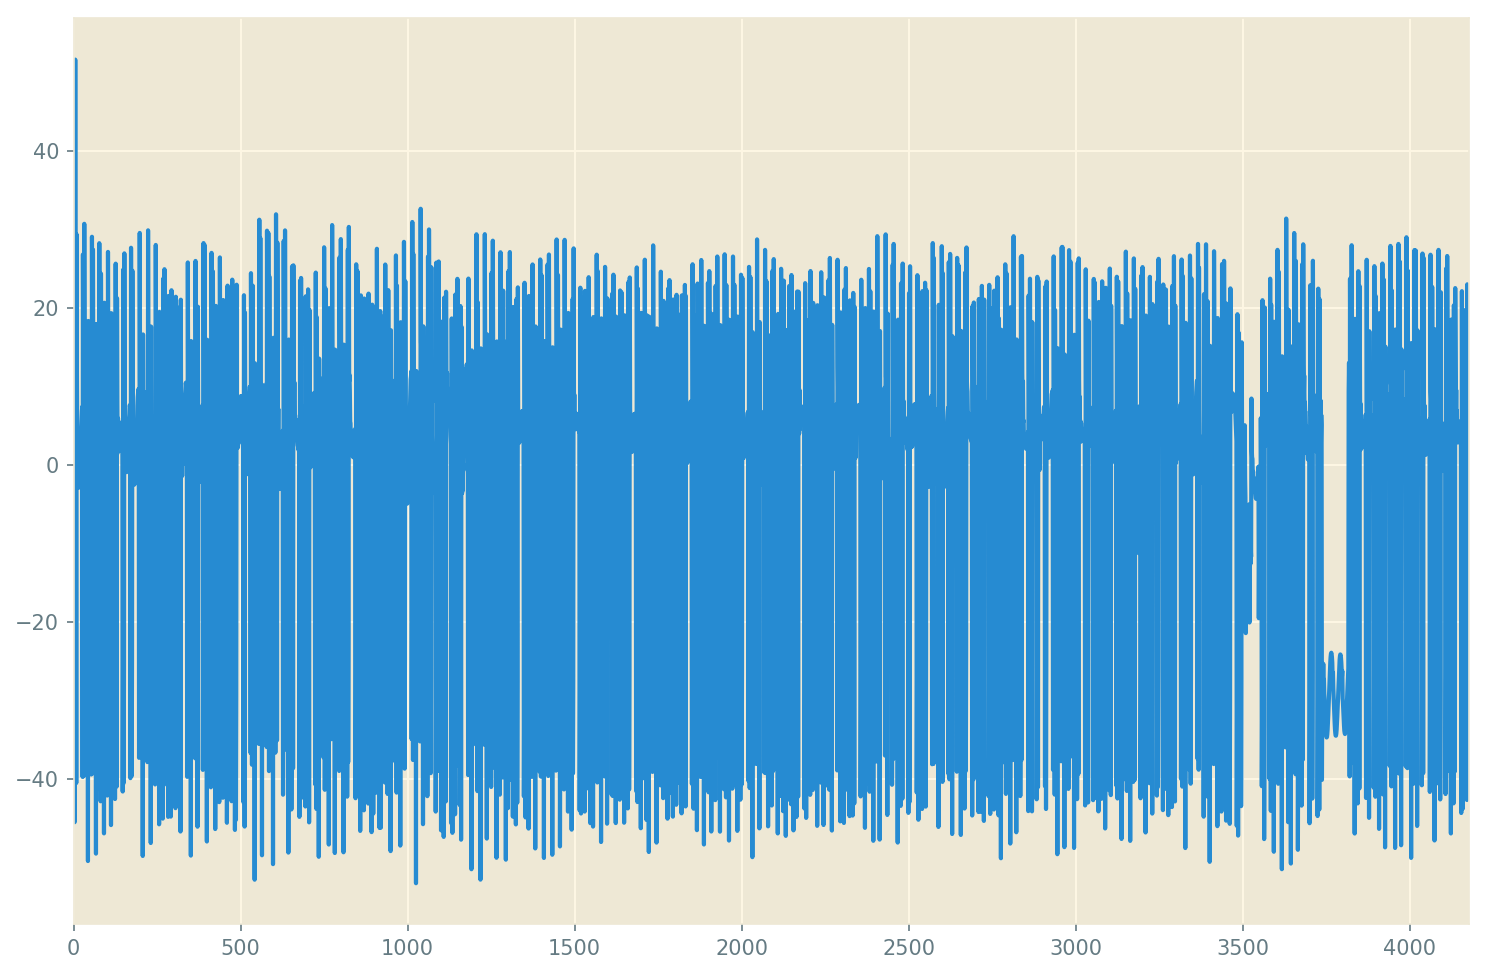

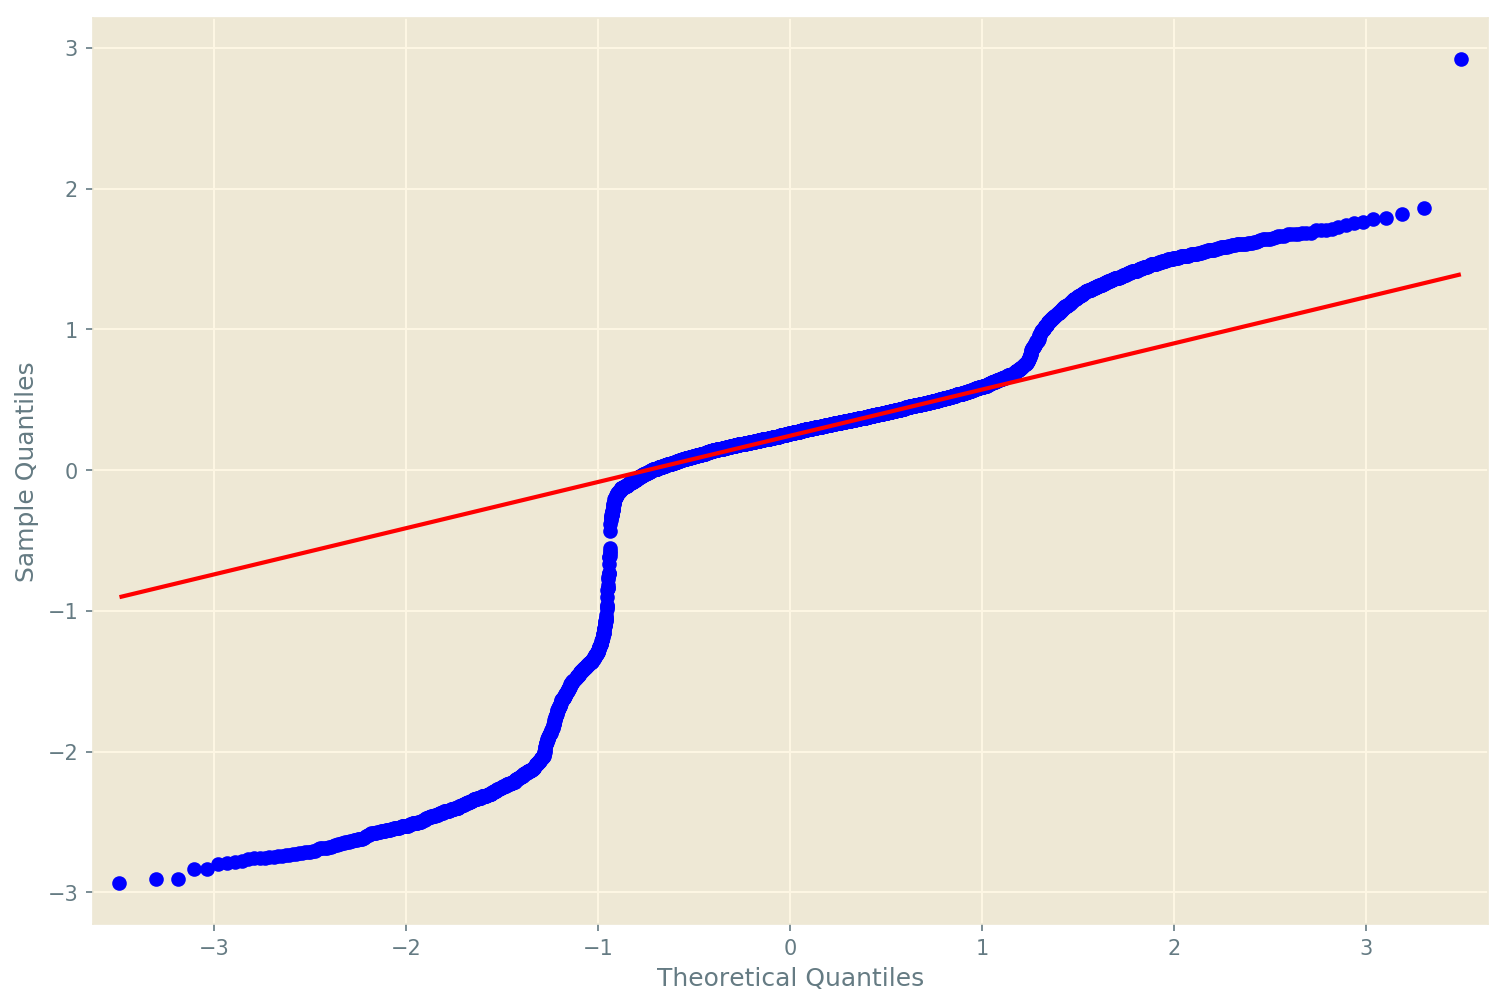

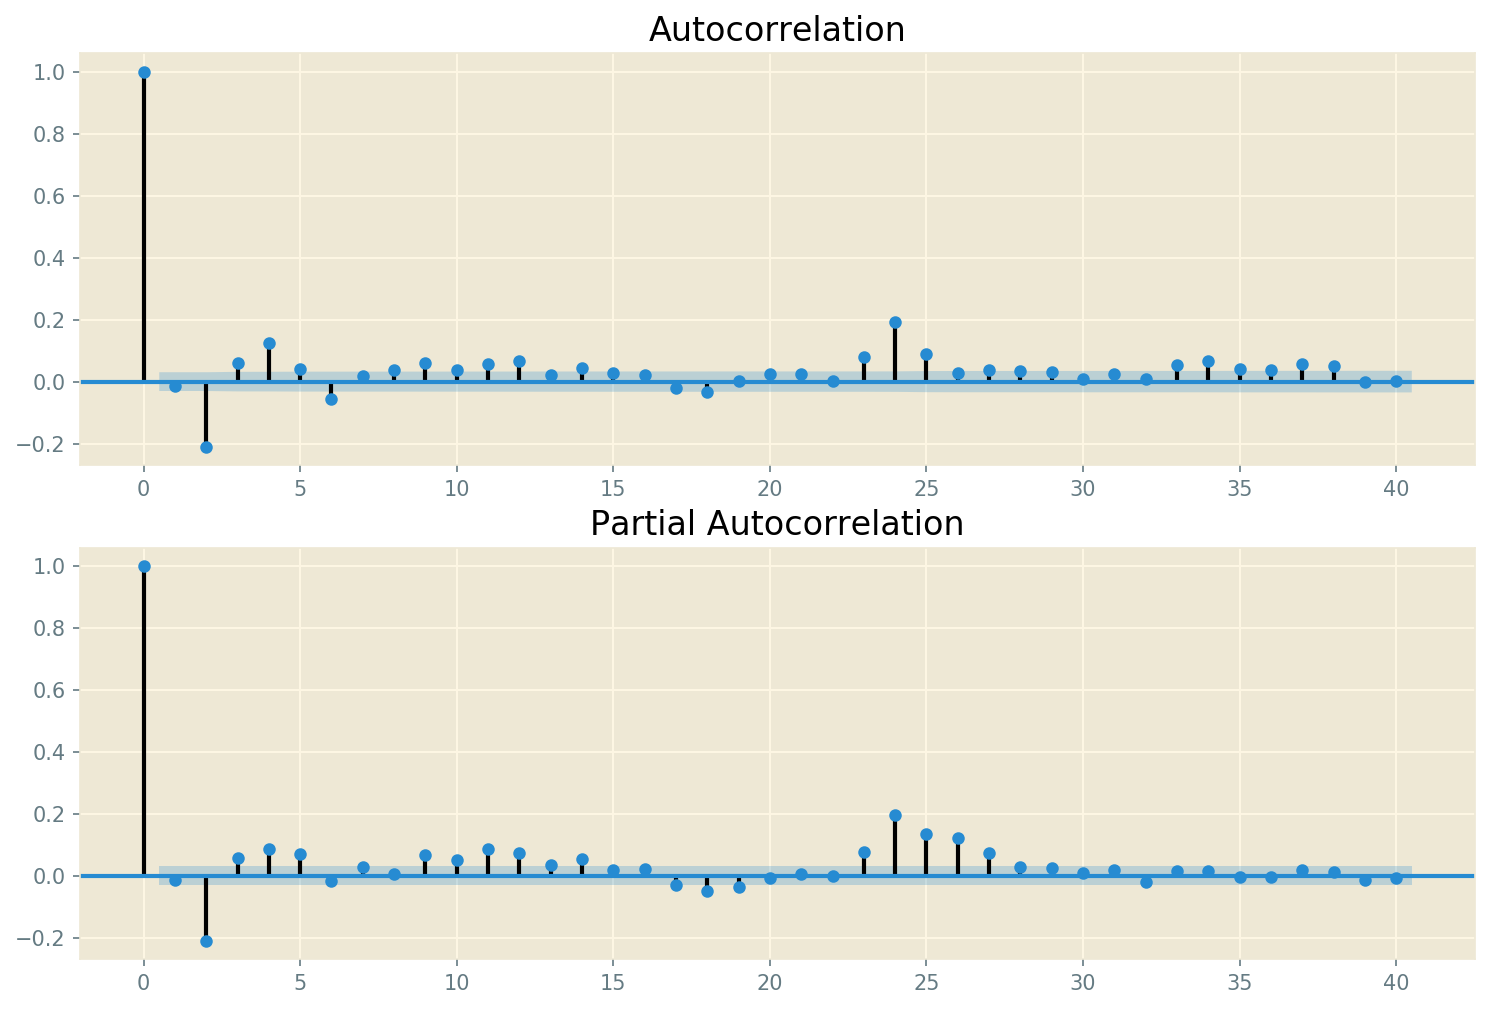

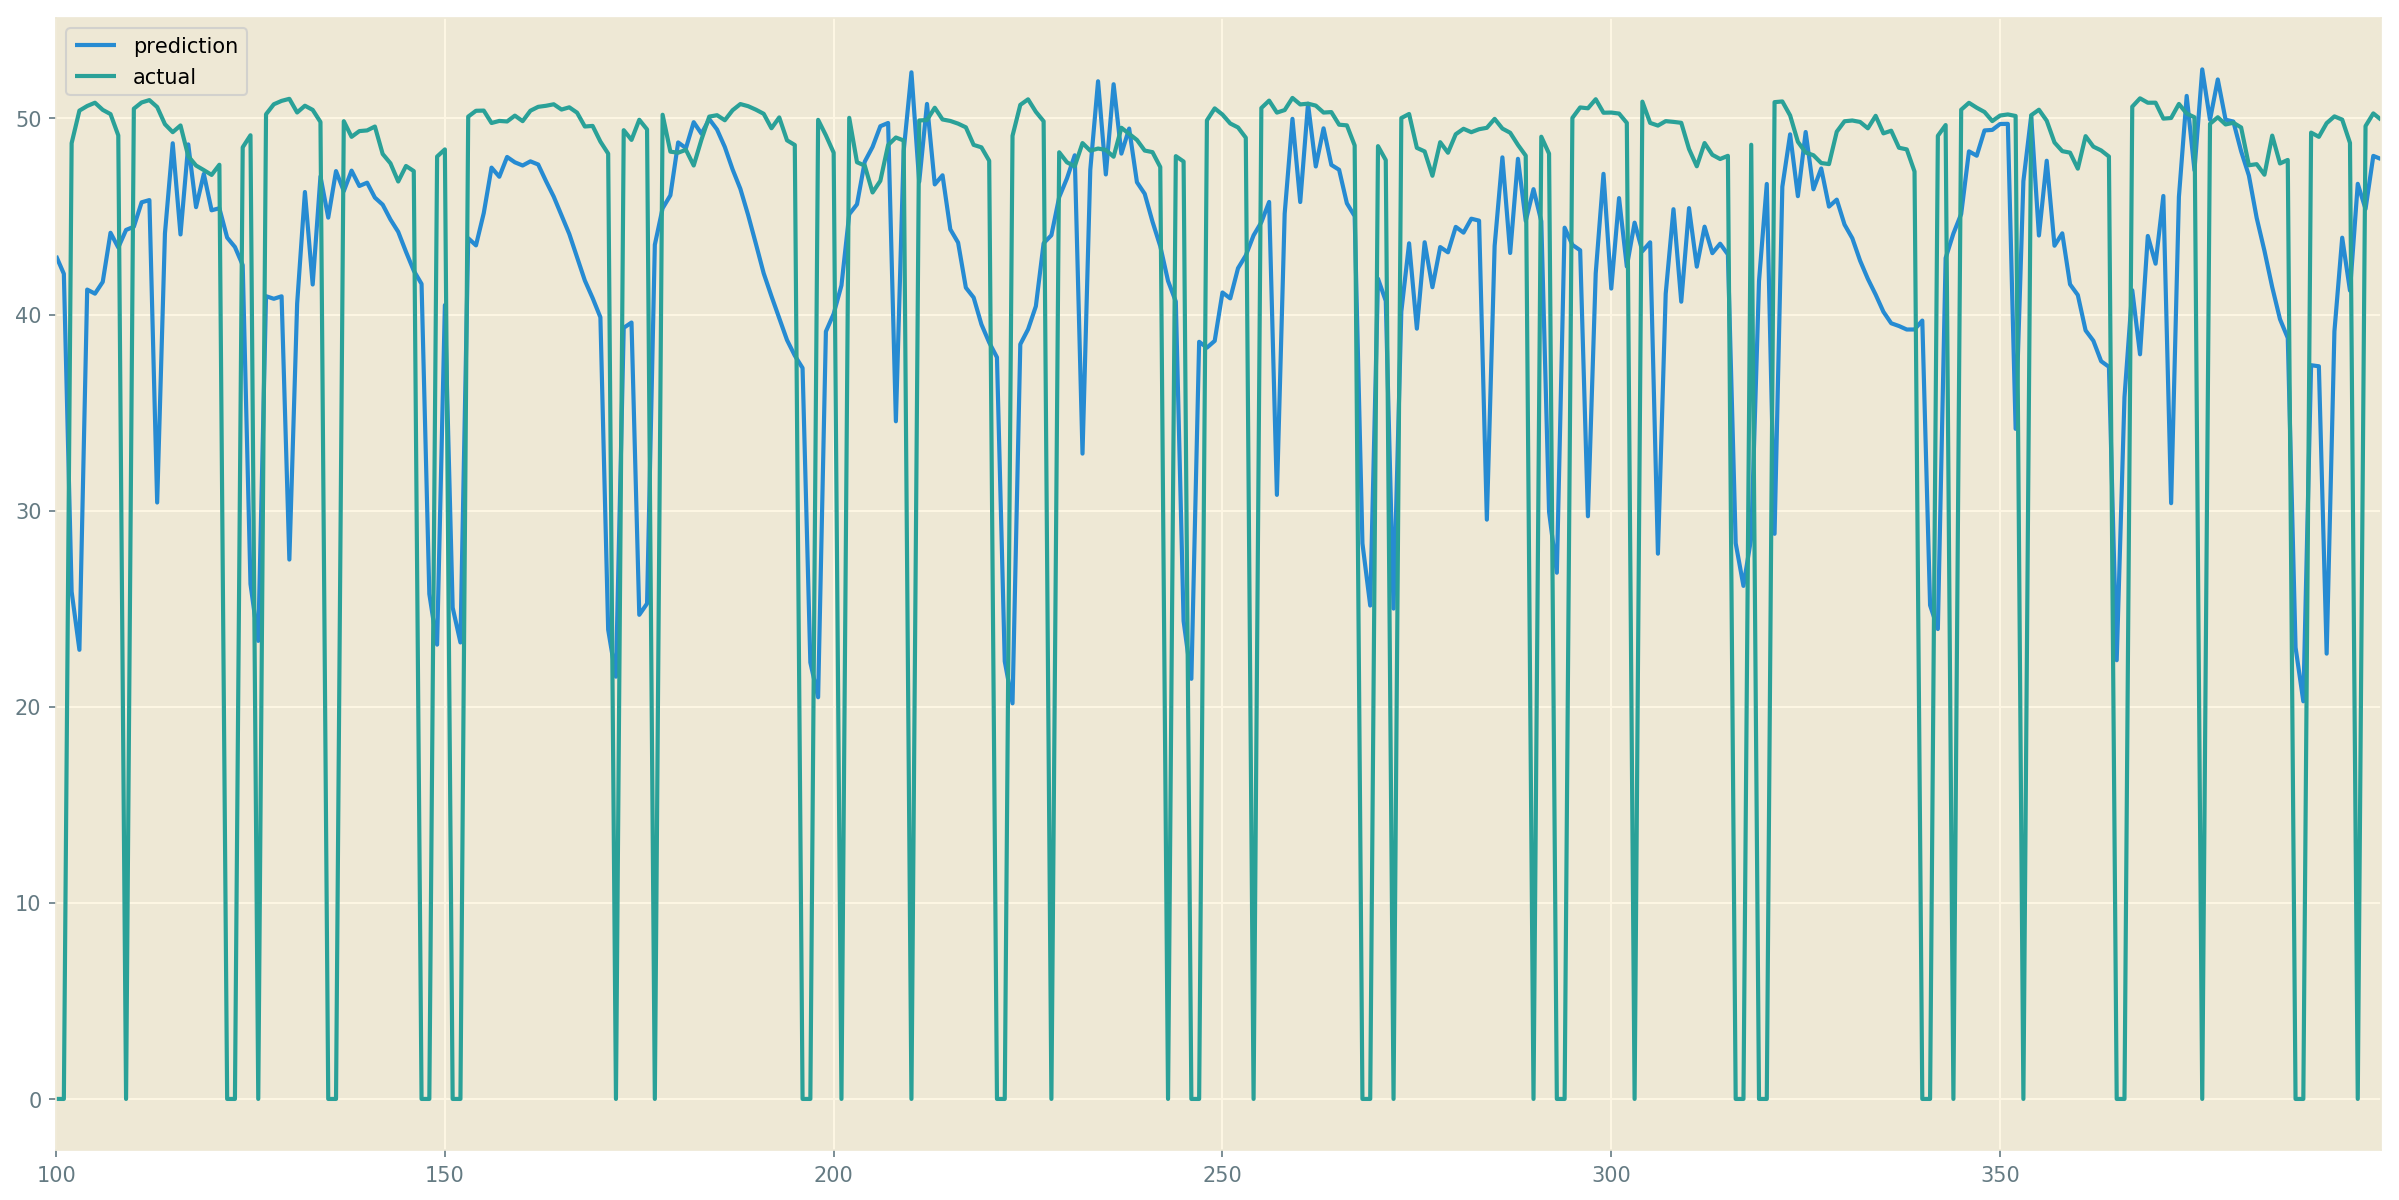

In [28]:
# param_sets = [(1,0), (2,0), (3,0), (4,0), (5,0), (6,0), (7,0), (8,0)] # best 2,0
# param_sets = [(2,0), (2,1), (2,2), (2,3), (2,4), (2,5), (2,6)] # best 2,5
# param_sets = [(2,5), (3,5), (4,5), (5,5)] # best 4,5
param_sets = [(4,5), (4,6), (4,7), (4,8)] # best 4,5

anomalies, resid = do_arma(df['F_PU7'], df_attacks[' F_PU7'], (4,5), df_attacks[' ATT_FLAG'])


In [29]:
plot_attacks(resid, df_attacks[' ATT_FLAG'], anomalies)

NameError: name 'plot_attacks' is not defined